In [1]:
using PyCall
using CSV
using Plots
using Dates
using Indicators
using Distributions
using DataFrames
using .Threads
using CategoricalArrays
using Statistics


In [129]:
include("labeling.jl")
include("hpc.jl")
include("MixtureModel.jl")
include("BetSizing.jl")

limitPrice (generic function with 1 method)

In [3]:
py"""
import yfinance
import datetime as dt
def get_data():
  enddate = dt.datetime.strptime("2021-01-01", "%Y-%m-%d").date()
  startdate = enddate - dt.timedelta(days=360*2) # for 5 years

  data = yfinance.download(tickers="AAPL", period="700d", interval="1h")
  return data
"""

In [4]:
df = py"get_data"();

[*********************100%***********************]  1 of 1 completed


In [5]:
py"""
import pandas as pd
import numpy as np

def get_ohlcv(df_group):
    ohlc = df_group['Close'].ohlc()
    ohlc['volume'] = df_group['Volume'].sum()
    return ohlc

def get_time_bar(df, freq="5Min"):
    df_group = df.groupby(pd.Grouper(freq=freq))
    
    ohlcv = get_ohlcv(df_group).dropna()
    return ohlcv.index , ohlcv.to_numpy()
"""

In [6]:
py"""
def reset_data_time(data):
  df  = data.copy()
  df.set_index(df.index.strftime("%Y-%m-%d"))
  return df
"""

In [7]:
indexs ,ohlcv = py"get_time_bar"(df, freq="1B")
index = indexs.strftime("%Y-%m-%d");

In [8]:
data = DataFrame(Dates = Date.(index,dateformat"y-m-d"),open = ohlcv[:,1] , high = ohlcv[:,2] , low = ohlcv[:,3] , close = ohlcv[:,4] , volume = ohlcv[:,5]);

In [9]:
close = select(data,["Dates" , "close"])
rets,std = dailyvol(close,32);

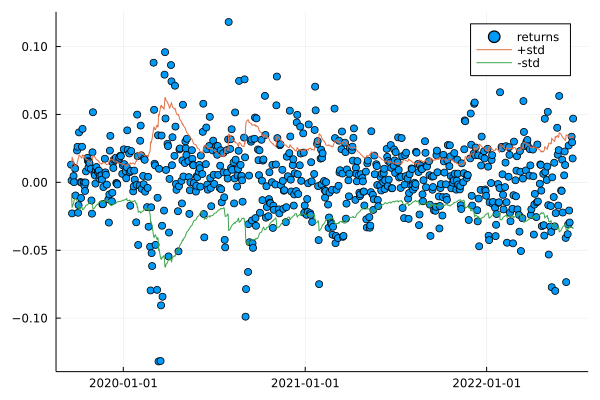

In [ ]:
x=rets[!,:x1]
scatter(x,rets[!,:x2] , label = "returns")
plot!(x,std[!,:x2] , label = "+std")
plot!(x,-1*std[!,:x2] , label = "-std")


In [10]:
numDays = 21
tEvents = events(close, 2);

In [11]:
t1 = verticalbarrier(close,tEvents,numDays);

In [12]:
events_ = events(close, tEvents, 1, std, 0.0; timestamp = t1.x2)

,date,timestamp,target
,Any,Date,Any
1,2019-10-04,2019-10-11,0.0201301
2,2019-10-11,2019-10-23,0.0202299
3,2019-10-23,2019-10-28,0.0155632
4,2019-11-01,2019-11-11,0.0196762
5,2019-11-13,2019-12-03,0.015068
6,2019-12-03,2019-12-05,0.0152661
7,2019-12-06,2019-12-16,0.0170106
8,2019-12-13,2019-12-16,0.0158761
9,2019-12-23,2019-12-26,0.0142096


In [13]:
out = label(events_,close);

In [14]:
concurrency = nConcurrencyEvents(events_,out,events_.date);

In [15]:
bets = DataFrame(Dates=concurrency.Dates)

,Dates
,Any
1,2019-10-04
2,2019-10-11
3,2019-10-23
4,2019-11-01
5,2019-11-13
6,2019-12-03
7,2019-12-06
8,2019-12-13
9,2019-12-23


In [16]:
mixturemodel = M2N(moments = zeros(5) .+ 100)
fit!(mixturemodel,concurrency.ct) ;
μ_1 , μ_2 , σ_1 ,σ_2 , p1 = mixturemodel.parameters

5-element Vector{Float64}:
 -2.267817463057676
  1.770069765194139
  0.6478787666478472
  1.1435879055756526
  0.4688466197516438

In [18]:
bets.gaussian = GaussianBet.(concurrency.ct;weights = [p1 , 1-p1] ,  means = [μ_1 , μ_2] ,sd = [σ_1 , σ_2]);

In [19]:
active_long_max = maximum(concurrency.active_long)
active_short_max = maximum(concurrency.active_short)

long_size = Array{Any}(undef, size(concurrency)[1])
for i in 1:length(long_size)
    long_size[i] = concurrency[i,"active_long"]/active_long_max
end

short_size = Array{Any}(undef, size(concurrency)[1])
for i in 1:length(short_size)
    short_size[i] = concurrency[i,"active_short"]/active_short_max
end

bets.budgeting = long_size - short_size;

In [20]:
X = copy(data)
features = DataFrame(Dates=Date.(index,dateformat"y-m-d"))

using Indicators

features.SMA_5 = sma(values(X[!,"close"]), n=5)
features.SMA_15 = sma(values(X[!,"close"]), n=15)
features.volume_ratio = sma(values(X[!,"volume"]), n=5)./sma(values(X[!,"volume"]), n=15);

In [21]:
features.RSI_15 = rsi(values(X[!,"close"]), n=15, ma=sma)
features.RSI_5 = rsi(values(X[!,"close"]), n=5, ma=sma);
features.upperband = Indicators.bbands(values(X[!,"close"]), n=15)[:,3] 
features.lowerband = Indicators.bbands(values(X[!,"close"]), n=15)[:,1];
features.MACD = Indicators.macd(values(X[!,"close"]), nfast=5, nslow=15)[:,1];
hlc = [values(X.high) values(X.low) values(X.close)]
features.Stochastic_5 = stoch(hlc, nK=5)[:,1]
features.Stochastic_15 = Indicators.stoch(hlc, nK=15)[:,1];

In [46]:
features = filter(row -> row[:Dates] in out.Dates, features)


X_train = features[1:trunc(Int, (size(features)[1]*0.70)),2:11]
X_test = features[trunc(Int, (size(features)[1]*0.70))+1:end,2:11]
y_train = features.label[1:trunc(Int, (size(features)[1]*0.70))]
y_test = features.label[trunc(Int, (size(features)[1]*0.70))+1:end];

In [49]:
using Statistics
scale(x) = (x .- Statistics.mean(filter(!isnan, x))) ./ Statistics.std(filter(!isnan, x))
X_trainn = Matrix{Any}(undef, size(X_train)[1], size(X_train)[2])

for i in 1:size(X_train)[2]
    X_trainn[:,i] = ((X_train)[:,i])
end

X_testt = Matrix{Any}(undef, size(X_test)[1], size(X_test)[2])

for i in 1:size(X_train)[2]
    X_testt[:,i] = scale(X_test[:,i])
end


In [102]:
fm = @formula(label ~ SMA_5 +SMA_15 + volume_ratio + RSI_5 + upperband + upperband + Stochastic_5 + Stochastic_15)
logit = glm(fm, features, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

label ~ 1 + SMA_5 + SMA_15 + volume_ratio + RSI_5 + upperband + Stochastic_5 + Stochastic_15

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error      z  Pr(>|z|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)     1.50209     0.641747     2.34    0.0193   0.244288      2.75989
SMA_5          -0.0817205   0.0393661   -2.08    0.0379  -0.158877     -0.00456427
SMA_15          0.110054    0.0467264    2.36    0.0185   0.0184723     0.201636
volume_ratio   -0.501312    0.414496    -1.21    0.2265  -1.31371       0.311085
RSI_5           0.00343354  0.00596461   0.58    0.5649  -0.00825688    0.015124
upperband      -0.03

In [103]:
prediction = GLM.predict(logit, features)
prediction = [x<0.5 ? -1 : 1 for x in prediction];

In [104]:
function confusion_matrix(A, B)
    actualPositives = sum(A .== 1)
    actualNegatives = sum(A .== -1)
    println("***************")
    print("Actual Positives: ")
    println(actualPositives)
    print("Actual Negatives: ")
    println(actualNegatives)
    println()
    truePositives = sum( (A .== B) .& (A .== 1) )
    print("True Positives: ")
    println(truePositives)
    trueNegatives = sum( (A .== B) .& (A .== -1) )
    print("True Negatives: ")
    println(trueNegatives)
    falsePositives = sum( .!(A .== B) .& (A .== -1) )
    print("False Positives: ")
    println(falsePositives)
    falseNegatives = sum( .!(A .== B) .& (A .== 1) )
    print("False Negatives: ")
    println(falseNegatives)
    println("***************")
    return [actualPositives, actualNegatives, truePositives, trueNegatives, falsePositives, falseNegatives]
end

confusion_matrix(2*features.label .- 1, prediction);

***************
Actual Positives: 162
Actual Negatives: 135

True Positives: 111
True Negatives: 72
False Positives: 63
False Negatives: 51
***************


In [105]:
features.predict =   prediction .+ 1 
features.meta_label  =  features.predict .!= features.label

fm = @formula(meta_label ~ SMA_5 +SMA_15 + volume_ratio + RSI_5 + upperband + upperband + Stochastic_5 + Stochastic_15 + predict)
logit = glm(fm, features, Binomial(), ProbitLink())
 


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

meta_label ~ 1 + SMA_5 + SMA_15 + volume_ratio + RSI_5 + upperband + Stochastic_5 + Stochastic_15 + predict

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                     Coef.   Std. Error      z  Pr(>|z|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)     2.54932      1.59078      1.60    0.1090   -0.568557     5.6672
SMA_5          -0.14071      0.0694955   -2.02    0.0429   -0.276919    -0.00450172
SMA_15          0.0948968    0.0883518    1.07    0.2828   -0.0782695    0.268063
volume_ratio   -1.25037      0.676931    -1.85    0.0647   -2.57713      0.0763928
RSI_5           0.00806485   0.00915164   0.88    0.3782   -0.00987204   0.0260017

In [106]:
probability = GLM.predict(logit, features)
prediction = [x<0.5 ? -1 : 1 for x in probability]

confusion_matrix(2*features.meta_label .- 1, prediction);

***************
Actual Positives: 225
Actual Negatives: 72

True Positives: 189
True Negatives: 58
False Positives: 14
False Negatives: 36
***************


In [107]:
bets_prob = betSizeProbability(probability, 2)

297-element Vector{Float64}:
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  ⋮
  0.2154146136014614
 -0.07369323133542549
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  0.04434933030230148
  1.0
  1.0
  0.06778307224128288

In [114]:
bets = filter(row -> row[:Dates] in features.Dates , bets)
bets.probability = bets_prob;

In [152]:
function create_signal_dataframe(bets , numberofcolumn , stepsize)
    signal = DataFrame(Dates=bets.Dates)
    signal.t1 = filter(row -> row[:date] in bets.Dates , events_).timestamp
    signal.signal = bets[!,numberofcolumn]
    averageSignal = AverageActiveSignals(signal)
    averageSignal = filter(row -> row[:date] in signal.Dates, averageSignal)
    signal.averageSignal = averageSignal.signal;
    signal.discreteSignal = DiscreteSignal(signal.averageSignal,stepsize)
    return signal
end

create_signal_dataframe (generic function with 1 method)

In [157]:
gaussiansignal = create_signal_dataframe(bets,2,0.1)
budgetingsignal = create_signal_dataframe(bets,3,0.1)
probabilitysignal = create_signal_dataframe(bets,4,0.1);


In [169]:
cum_rets = DataFrame(Dates=gaussiansignal.Dates)

returns = gaussiansignal.discreteSignal .* out.ret
cum_rets.gaussian = (cumprod(returns .+ 1)) .- 1

returns = budgetingsignal.discreteSignal .* out.ret
cum_rets.budgeting = (cumprod(returns .+ 1)) .- 1

returns = probabilitysignal.discreteSignal .* out.ret
cum_rets.probability = (cumprod(returns .+ 1)) .- 1;

cum_rets.buyandhold  =  (cumprod(out.ret .+ 1)) .- 1;

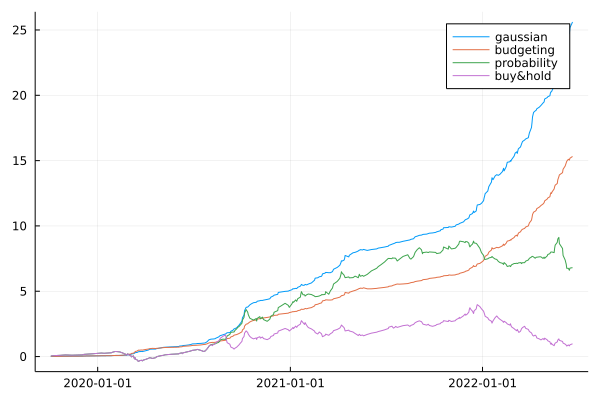

In [170]:
plot(cum_rets.Dates ,cum_rets.gaussian , label = "gaussian")
plot!(cum_rets.Dates ,cum_rets.budgeting , label = "budgeting")
plot!(cum_rets.Dates ,cum_rets.probability , label = "probability")
plot!(cum_rets.Dates ,cum_rets.buyandhold , label = "buy&hold")